In [1]:
import cv2
import numpy as np
import math 
import matplotlib.pyplot as plt
import random

In [2]:
def display_img_arr(img_arr, r, c, dim,titles_arr):
    fl = 0
    fig = plt.figure(figsize = dim)
    for i in range(r):
        for j in range(c):
            if len(img_arr) == fl:
                break
            ax1 = fig.add_subplot(r, c, fl + 1)
            ax1.set_title(titles_arr[fl], fontsize = 20)
            ax1.imshow(img_arr[fl], cmap = 'gray')
            fl = fl + 1
    plt.show()

In [3]:
def match(img, SE):
    rows = img.shape[0]
    cols = img.shape[1]
    for i in range(rows):
        for j in range(cols):
            im_cur = img[i][j]
            if SE[i][j] == im_cur:
                continue
            if SE[i][j] == -1:
                continue
            return 0
    return 1


def hit_or_miss_transformation(img, SE):
    m,n = img.shape
    len_padding = SE.shape[0]//2
    result = np.zeros((m,n))
    
    for i in range(len_padding, m - len_padding):
        for j in range(len_padding, n - len_padding):
            slice_arr = img[i-len_padding:i+len_padding+1][j-len_padding:j+len_padding+1]
            if match(slice_arr, SE)!=0:
                result[i][j] = 1
    return result

def LaberOrdering(image):
    resultult_img = np.zeros(image.shape)
    ord_ = {}
    n = image.shape[0]
    m = image.shape[1]
    uniques = np.unique(image)
    for i in range(len(uniques)):
        ord_[uniques[i]] = i
    
    for i in range(n):
        for j in range(m):
            resultult_img[i][j] = ord_[image[i][j]]
    
    return resultult_img

def one_th_Pass_eight_comp(image, len_padding):
    parent_lst = {0:0} 
    count = 0 
    resultult_img = np.zeros(image.shape)
    
    rowh = image.shape[0] - len_padding
    colh = image.shape[1] - len_padding
    for i in range(len_padding, rowh):
        for j in range(len_padding, colh):
            neighbours = []
            cur = 0
            if image[i][j]:
                
                if resultult_img[i][j-1]:
                    neighbours.append(resultult_img[i][j-1])
                    
                if resultult_img[i-1][j+1]:
                    neighbours.append(resultult_img[i-1][j+1])
                    
                if resultult_img[i-1][j]:
                    neighbours.append(resultult_img[i-1][j])
                    
                if resultult_img[i-1][j-1]:
                    neighbours.append(resultult_img[i-1][j-1])

                neighbours = np.array(neighbours)
                if len(neighbours) == 0:
                    count = count + 1
                    cur = count
               
                elif resultult_img[i][j-1] == resultult_img[i-1][j] :
                    tmp = neighbours[0]
                    cur = neighbours[0]
               
                else:
                    for k in range(len(neighbours)):
                        neighbour = neighbours[k]
                        if neighbour in parent_lst:
                            if parent_lst[neighbour] < min(neighbours):
                                parent_lst[neighbour] = parent_lst[neighbour]
                            else:
                                parent_lst[neighbour] = min(neighbours)
                        else:
                            parent_lst[neighbour] = min(neighbours)
                    cur = min(neighbours)
                    
                resultult_img[i][j] = cur
    return resultult_img, parent_lst


def eight_connected_component(image, window_size):
    m,n = image.shape
    len_padding = window_size//2
    first = np.copy(image)
    first, parent_lst = one_th_Pass_eight_comp(image, len_padding)
    second = np.zeros(first.shape)
    for i in range(len_padding, m - len_padding):
        for j in range(len_padding, n - len_padding):
            cd = first[i][j]
            flag = 0
            while cd in parent_lst and parent_lst[cd] != cd:
                cd = parent_lst[cd]
            second[i][j] = cd
    ordered_Image = LaberOrdering(second)
    return ordered_Image[len_padding:image.shape[0]-len_padding, len_padding:image.shape[1]-len_padding].astype(np.uint8)


def colourise(image):
    h = image.shape[0]
    w = image.shape[1]
    colors = []
    for i in range(300):
        colors.append([random.randint(0,255),random.randint(0,255),random.randint(0,255)])
    
    new_image = np.zeros((h, w, 3))
    for i in range(h):
        for j in range(w):
            if  image[i][j]:
                new_image[i][j] = colors[image[i][j]]
            
    new_image = new_image.astype(np.uint8)
    return new_image



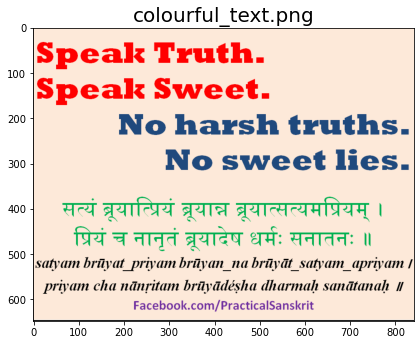

In [4]:
image = cv2.imread("../images/colourful_text.png",1)[15:-15,15:-15]
display_img_arr([cv2.cvtColor(image, cv2.COLOR_BGR2RGB)], 1, 2, (15, 15), ['colourful_text.png'])


No of components of color [125  73  31]
27
No of components of color [  0   0 255]
24
No of components of color [0 0 0]
243
No of components of color [ 80 176   0]
79
No of components of color [160  48 112]
34


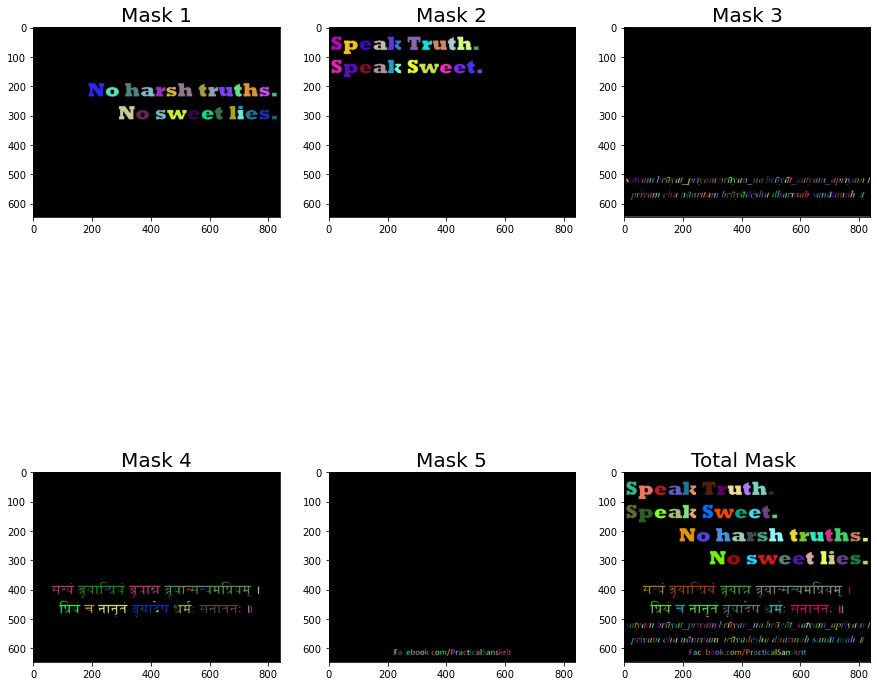

In [5]:

colors_lst, counts = np.unique(image.reshape(-1, image.shape[2]), axis=0, return_counts=True)
tmp = np.argsort(counts)
color_indices = np.flipud(tmp)
colors_lst = colors_lst[color_indices[1:6],:]

masks = []
m = image.shape[0]
n = image.shape[1]
total = np.zeros((m,n))
for k in range(len(colors_lst)):
    m_img = np.zeros((m,n))
    for i in range(m):
        for j in range(n):
            bool_val = np.array_equal(image[i][j], colors_lst[k])
            if bool_val:
                m_img[i][j] = 1
    masks.append(m_img)
    

for i in range(len(masks)):
    total += masks[i] 
masks.append(total)


num_compo = []
connected = []
for i in range(len(masks)):
    connected_image = eight_connected_component(masks[i], 3)
    _, counts = np.unique(connected_image, return_counts=True)
    connected.append(connected_image)
    num_compo.append(len(counts))

for i in range(len(colors_lst)):
    print("No of components of color " + str(colors_lst[i]))
    print(str(num_compo[i]-1))

images = []
titles = []
for i in range(5):
    titles.append('Mask '+str(i+1))
    images.append(colourise(connected[i].astype(np.uint8)))
titles.append('Total Mask ')
images.append(colourise(connected[5].astype(np.uint8)))

display_img_arr(images, 2, 3, (15, 15), titles)


In [6]:
def Count_EmptyRegions(image):
    conn_comp = np.copy(image)
    conn_comp = eight_connected_component(conn_comp, 3)
    oneEmptyRegion = []
    twoEmptyRegions = []
    unique= np.unique(conn_comp)
    for i in range(len(unique)) :
        if unique[i]:
            comp_image = np.zeros(conn_comp.shape)
            comp_image[conn_comp==unique[i]] = 1
            plt.show()
            holes = len(np.unique(eight_connected_component( 1 - comp_image, 3)))-2 

            if holes == 1:
                oneEmptyRegion.append(unique[i])
            if holes == 2:
                twoEmptyRegions.append(unique[i])   
    res = np.zeros(conn_comp.shape)  
    res2 = np.zeros(conn_comp.shape)  
    for x in oneEmptyRegion:
        res[np.where(conn_comp==x)] = 1
    for x in twoEmptyRegions:
        res2[np.where(conn_comp==x)] = 1   
    return res, res2


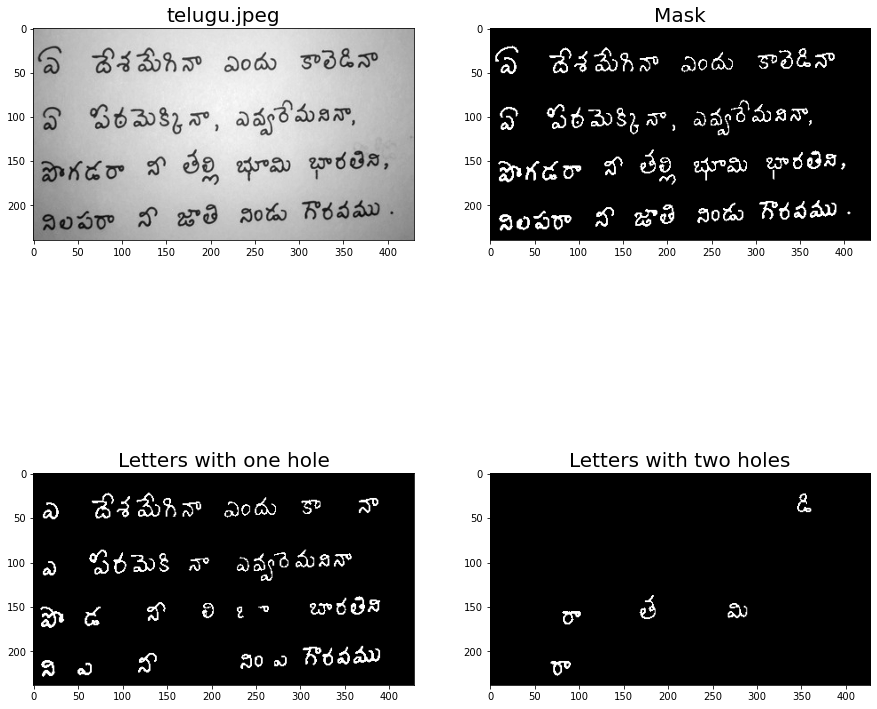

In [7]:
titles = []
telu = cv2.imread("../images/telugu.jpeg",0)[52:292,52:482]
titles.append('telugu.jpeg')
binary_telu = np.where(telu <= 90, 1, 0)
titles.append('Mask')
oneEmptyRegionTelugu, twoHoleTelugu = Count_EmptyRegions(binary_telu)
titles.append('Letters with one hole')
titles.append('Letters with two holes')
display_img_arr([telu, binary_telu, oneEmptyRegionTelugu,twoHoleTelugu],2, 2, (15, 15), titles)

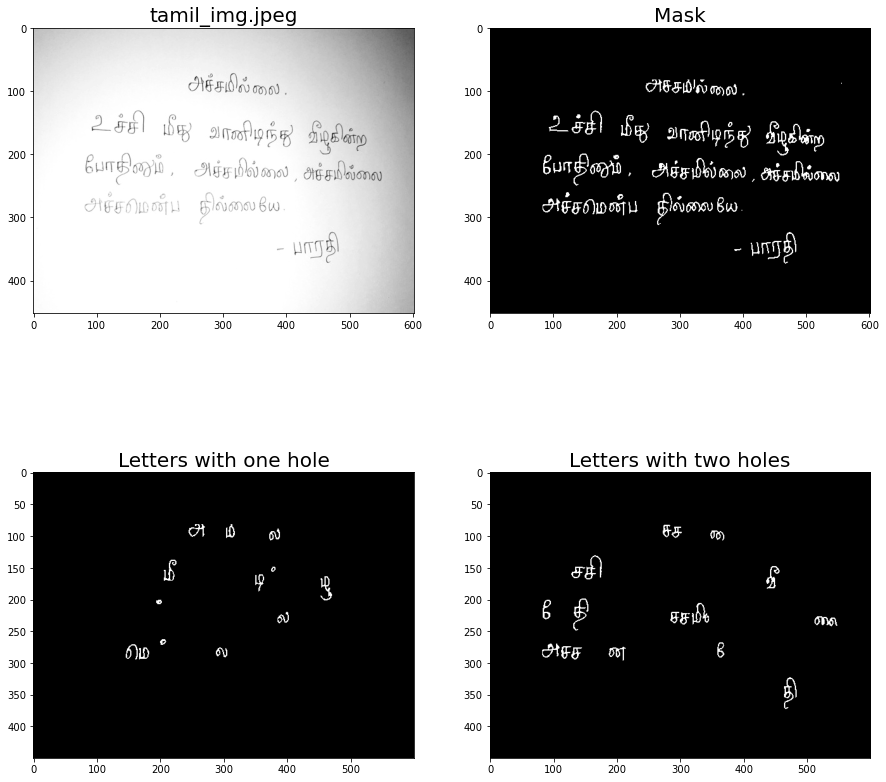

In [8]:
titles = []
images = []
tamil_img = cv2.imread("../images/tamil.jpeg",0)
images.append(tamil_img)
titles.append('tamil_img.jpeg')
tamil_img = cv2.adaptiveThreshold(tamil_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 199, 5) 


#SE = np.array([[0, 1], [1, 1]])
SE = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,2))

thresh_tamil_img = np.zeros(tamil_img.shape)
thresh_tamil_img[82:402,82:555] = tamil_img[82:402,82:555]

img2 = cv2.erode(cv2.dilate(thresh_tamil_img,SE,iterations=1),SE,iterations=1)
images.append(img2)
titles.append('Mask')

oneEmptyRegionTelugu, twoHoleTelugu = Count_EmptyRegions(img2)
images.append(oneEmptyRegionTelugu)
titles.append('Letters with one hole')
images.append(twoHoleTelugu)
titles.append('Letters with two holes')
display_img_arr(images,2, 2, (15, 15), titles)
